In [1]:
import os
import sys
os.chdir('..')

if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
dataset = pd.read_csv('data/cleaned_tripadvisor_reviews.csv')

In [4]:
dataset.head()

,Unnamed: 0,Review,Rating,cleaned_text
0,0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking get good deal sta...
1,1,ok nothing special charge diamond member hilto...,2,ok nothing special charge diamond member hilto...
2,2,nice rooms not 4* experience hotel monaco seat...,3,nice room 4 experience hotel monaco seattle go...
3,3,"unique, great stay, wonderful time hotel monac...",5,unique great stay wonderful time hotel monaco ...
4,4,"great stay great stay, went seahawk game aweso...",5,great stay great stay go seahawk game awesome ...


In [5]:
print('the shape of the dataset is: ', dataset.shape)
print('')
print('number of NA values: ', dataset.isna().sum())

the shape of the dataset is:  (20491, 4)

number of NA values:  Unnamed: 0      0
Review          0
Rating          0
cleaned_text    0
dtype: int64


## **Analysis of Class Imbalance**


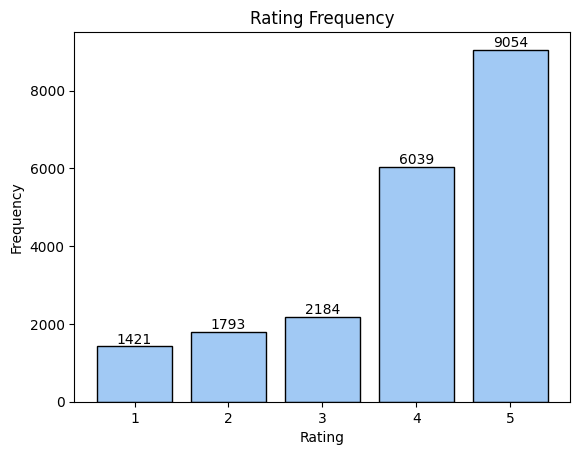

In [22]:
class_counts = dataset['Rating'].value_counts().sort_index()

plt.bar(class_counts.index, class_counts, color=sns.color_palette("pastel")[0], edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Rating Frequency')
for i, value in enumerate(class_counts):
    plt.text(i + 1, value + 0.1, str(value), ha='center', va='bottom', fontsize=10)
plt.show()



### Analysis of Class Imbalance

The bar plot highlights a noticeable class imbalance in our hotel reviews dataset, with a higher frequency of ratings 4 and 5 compared to 1, 2, and 3. This imbalance can impact model performance especially as the number of rating 1, 2 or 3 is relatively small for Data science model.

The nature of hotel reviews may inherently lead to more positive ratings, creating an imbalance.



In [7]:
dataset.describe()

,Unnamed: 0,Rating
count,20491.000000,20491.000000
mean,10245.000000,3.952223
std,5915.386519,1.233030
min,0.000000,1.000000
25%,5122.500000,3.000000
50%,10245.000000,4.000000
75%,15367.500000,5.000000
max,20490.000000,5.000000


## **Analysis of the lenght of the reviews**

In [8]:
n_words = dataset['Review'].str.split().str.len()
n_chars = dataset['Review'].str.len()

In [9]:
pd.DataFrame(n_words.describe())

,Review
count,20491.000000
mean,104.375824
std,100.656586
min,7.000000
25%,48.000000
50%,77.000000
75%,124.000000
max,1931.000000


the max value is far from the mean value, so we can conclude that the distribution is skewed to the right.

In [34]:
n_words_above = n_words[n_words > n_words.mean() + 3*n_words.std()].count()
print('Number of word threshold ', n_words.mean() + 3*n_words.std())
print('Number of reviews with more than 3 standard deviations above the mean: ', n_words_above)

Number of word threshold  406.3455815395075
Number of reviews with more than 3 standard deviations above the mean:  377


### Decision to Reduce the dataset:

1. **Identification of Extreme Outliers:**
   - We observe that a subset of reviews contains an exceptionally high number of words, with some exceeding 3 standard deviations above the mean.
2. **Word Count Threshold:**
   - The calculated word count threshold above 3 standard deviations is approximately 406.35.
3. **Number of Affected Reviews:**
   - A total of 377 reviews have word counts exceeding this threshold.

In [33]:
# count n_words_above by rating
n_words_above_by_rating = dataset.loc[n_words > n_words.mean() + 3*n_words.std(), 'Rating'].value_counts().sort_index()
n_words_above_by_rating

1     30
2     56
3     50
4    126
5    115
Name: Rating, dtype: int64

## **Statistical Validation of Data Distribution**

To rigorously assess the impact of removing extreme outliers on the distribution of word lengths, we employ the Kolmogorov-Smirnov (KS) test. This statistical test allows us to determine whether the distribution of Rating that we are removing corresponds to the distribution of the entire dataset.

we want to be sure that we are not removing a part of the dataset that correspond to a specific class, for exemple if all the reviews above where class 1, we would be removing an important information to our dataset in addition to remove datas in a class where we already miss some datas.


In [47]:
from scipy.stats import ks_2samp

original_data = dataset['Rating']
data_to_remove = dataset.loc[n_words > n_words.mean() + 3*n_words.std(), 'Rating']

# Effectue le test de Kolmogorov-Smirnov
ks_statistic, ks_p_value = ks_2samp(original_data, filtered_data)

# Affiche les résultats du test
print(f"KS Statistic: {ks_statistic}")
print(f"P-Value: {ks_p_value}")

# Interprète les résultats
if ks_p_value < 0.05:
    print("The distribution of ratings that we are removing significantly differs from the overall distribution.")
else:
    print("The distribution of ratings that we are removing is similar to the overall distribution.")


KS Statistic: 0.0025643034838067624
P-Value: 0.9999998860394511
The distribution of ratings that we are removing is similar to the overall distribution.



### **Similar Distributions:**
  - With a p-value of approximately 1.0 (0.9999998860394511), we find that the distribution of ratings that we are removing is indeed similar to the overall distribution. This supports our decision to remove extreme outliers without introducing biases.



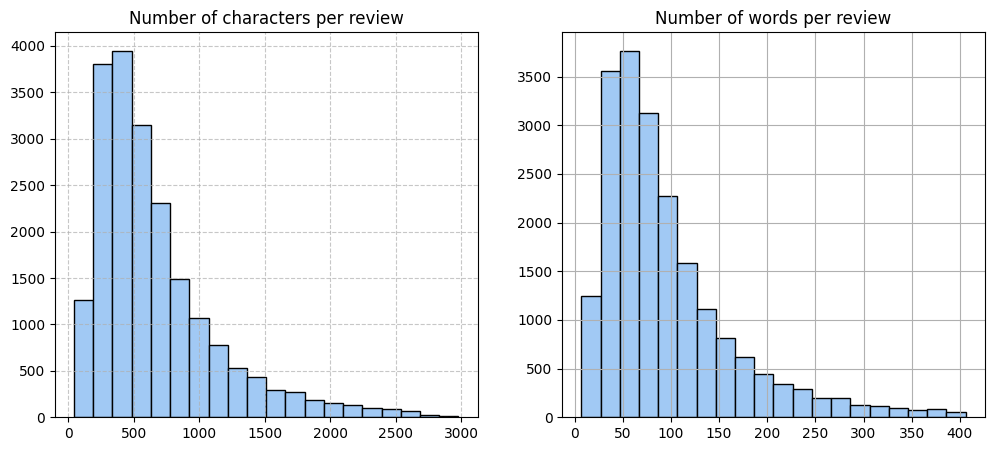

In [69]:
filtered_words = dataset.loc[n_words < n_words.mean() + 3*n_words.std(), 'Review']
n_filtered_words = filtered_words.str.split().str.len()
n_filtered_chars = filtered_words.apply(len) 

plt.subplot(1,2,1)
plt.title('Number of characters per review')
n_filtered_chars.hist(bins=20, figsize=(12,5), color= sns.color_palette("pastel")[0], edgecolor='black')
plt.grid(axis='both', linestyle='--', alpha=0.7)

plt.subplot(1,2,2)
plt.title('Number of words per review')
n_filtered_words.hist(bins=20, figsize=(12,5), color= sns.color_palette("pastel")[0], edgecolor='black')
plt.show()

We observe that the distribution of reviews is right-skewed, indicating that the majority of reviews tend to have lower values, while there are a few exceptional reviews with significantly higher values

## ***Verification for the pre processing pipeline***

Before to apply the preprocessing pipeline I want to know if it will be necessary to appli those preprocessing steps as I know that the datas has been already cleaned before to be posted on kaggle so a big part of the job has been done and I do not want to use an useless step in my pipeline.

In [11]:
# count if there emoticon in the review
dataset['Review'].str.contains(':\)|:\(|;\)|;\(|:-\)|:-\(|;-\)|;-\(').sum()

0

# ***What are the most common words in the reviews?***

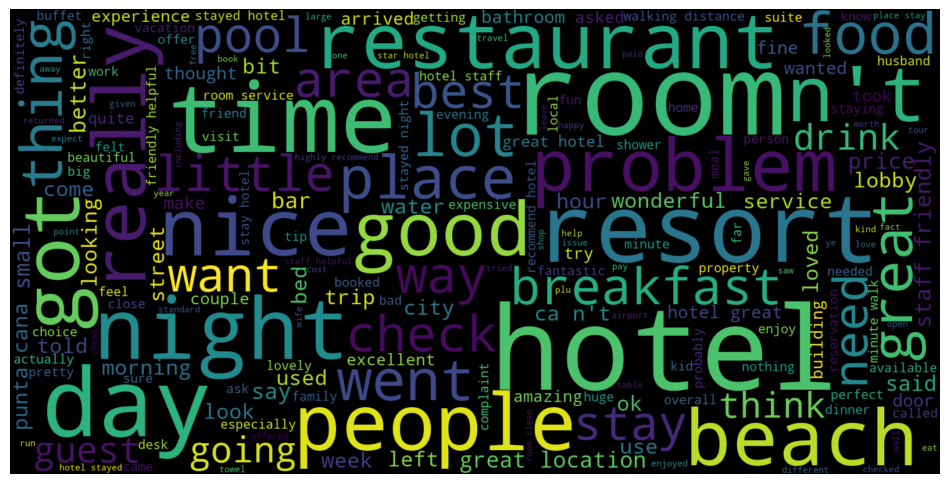

In [12]:
# display the 50 words the most used in the reviews
from collections import Counter
from wordcloud import WordCloud
Counter(" ".join(dataset["Review"]).split()).most_common(50)
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(" ".join(dataset["Review"]))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


From the wordcloud it seems like we have a lot of positive words: "amazing", "wonderful", "good", "friendly", et "great" what correspond to the fact that most of the review are positive (4 and 5). on the other way we notice "problem" that describe a negative review. these particular words will probably ne really usefull for the classification of a review. 

some words that are really used may demonstrate the things that are really important for a customers as for exemple: "restaurant", "beach", "pool", "breakfast". we can imagine that when these words are used with the positive words that we talked about, the Rating is very likely to be good. 

## Kolmogorov-Smirnov Test Results for Rating Distributions

The Kolmogorov-Smirnov (KS) test was applied to assess the similarity between the global distribution of review lengths and the distribution of review lengths for each unique rating.


In [79]:
from scipy.stats import ks_2samp

global_distribution = dataset['Review'].apply(len)

ks_results = []

for rating_value in dataset['Rating'].unique():
    rating_distribution = dataset[dataset['Rating'] == rating_value]['Review'].apply(len)
    ks_statistic, ks_p_value = ks_2samp(global_distribution, rating_distribution)
    
    # Stocker les résultats dans la liste
    ks_results.append({
        'Rating': rating_value,
        'KS Statistic': ks_statistic,
        'P-Value': ks_p_value,
        'Similar Distribution': ks_p_value >= 0.05  
    })

# Afficher les résultats
for result in ks_results:
    print(f"Rating {result['Rating']}:")
    print(f"  KS Statistic: {result['KS Statistic']}")
    print(f"  P-Value: {result['P-Value']}")
    print(f"  Similar Distribution: {result['Similar Distribution']}")
    print()


Rating 4:
  KS Statistic: 0.012760758807603745
  P-Value: 0.4297467381805442
  Similar Distribution: True

Rating 2:
  KS Statistic: 0.1345477996502103
  P-Value: 1.701808486904262e-26
  Similar Distribution: False

Rating 3:
  KS Statistic: 0.05694296146811889
  P-Value: 5.267042046072907e-06
  Similar Distribution: False

Rating 5:
  KS Statistic: 0.047610853135811815
  P-Value: 8.291671358899988e-13
  Similar Distribution: False

Rating 1:
  KS Statistic: 0.043832909805307185
  P-Value: 0.011745360093490528
  Similar Distribution: False



### Interpretation:

- For Rating 4, the distribution of review lengths is similar to the overall distribution.
- For Ratings 2, 3, 5, and 1, the distributions of review lengths are significantly different from the overall distribution.

These findings suggest that the length of reviews varies across different ratings, with some ratings showing distinct patterns in review length compared to the overall distribution. this data has an impact on the result.

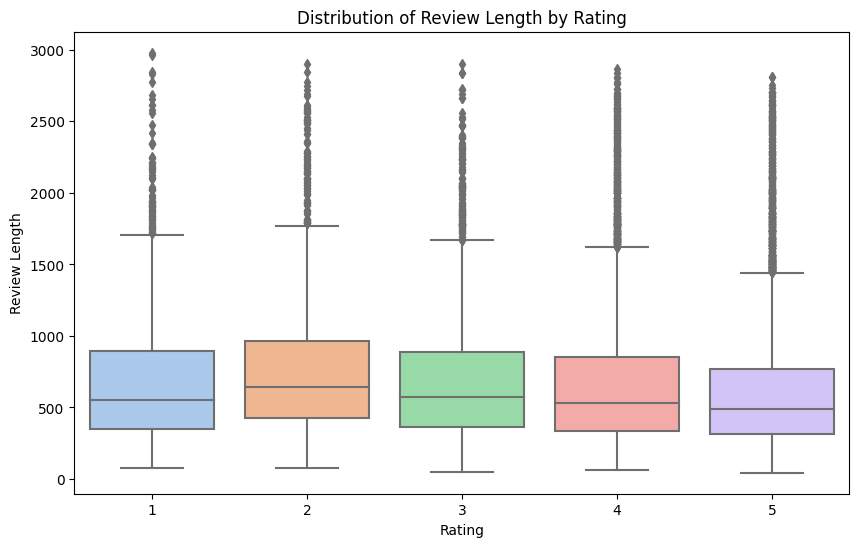

In [84]:
filtered_data = dataset.loc[n_words < n_words.mean() + 3*n_words.std()]

plt.figure(figsize=(10, 6))
sns.boxplot(x='Rating', y=filtered_data['Review'].apply(len), data=filtered_data, palette="pastel")
plt.title('Distribution of Review Length by Rating')
plt.xlabel('Rating')
plt.ylabel('Review Length')
plt.show()